# Red Light Intersection Crash Analysis

Linear regression analysis of factors affecting red light crashes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from modules.myfuncs import *
import warnings
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import sqlite3
# import dask
# import dask.dataframe as dd
import gc

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100

In [2]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db


In [3]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t-' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('intersction_locations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('signal_crashes',)]
cam_locations
	-camera_id
	-intersection
	-address
	-latitude
	-longitude
	-day

cam_startend
	-camera_id
	-start
	-end

daily_violations
	-intersection
	-camera_id
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

intersction_locations
	-intersection
	-latitude
	-longitude

all_crashes
	-crash_record_id
	-rd_no
	-crash_date
	-posted_speed_limit
	-traffic_control_device
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-beat_of_occurrence
	-num_units
	-most_severe_injury
	-injuries_total
	-injuries_fatal

## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

In [52]:
# LINK daily_violations to hourly_congestion through intersection_cams
crash_df = pd.read_sql_query('''
                                SELECT wx.temp,
                                        wx.snow_1h + wx.rain_1h as precip,
                                        wx.snow_1h,
                                        wx.rain_1h,
                                        wx.year,
                                        wx.month,
                                        wx.hour,
                                        wx.weekday,
                                        c.region_id,
                                        c.speed,
                                        cr.posted_speed_limit,
                                        cr.first_crash_type,
                                        cr.first_crash_type,
                                        cr.trafficway_type,
                                        cr.alignment,
                                        cr.roadway_surface_cond,
                                        cr.road_defect,
                                        cr.crash_type,
                                        cr.damage,
                                        cr.prim_contributory_cause,
                                        cr.sec_contributory_cause,
                                        cr.most_severe_injury,
                                        cr.injuries_total,
                                        cr.injuries_fatal,
                                        cr.injuries_incapacitating,
                                        cr.injuries_non_incapacitating,
                                        cr.injuries_reported_not_evident,
                                        cr.injuries_no_indication,
                                        cr.injuries_unknown,
                                        cr.lane_cnt,
                                        cr.work_zone_i,
                                        cr.work_zone_type,
                                        cr.workers_present_i,
                                        cr.intersection
                                        cr.region_id
                                FROM hourly_weather as wx
                                JOIN hourly_congestion as c
                                  ON wx.year = c.year
                                      AND wx.month = c.month
                                      AND wx.day = c.day
                                      AND wx.hour = c.hour
                                JOIN signal_crashes as cr
                                  ON wx.year = cr.year
                                      AND wx.month = cr.month
                                      AND wx.day = cr.day
                                      AND wx.hour = cr.hour
                                    ''', conn)

In [122]:
# TRY 2
# LINK daily_violations to hourly_congestion through intersection_cams
crash_df = pd.read_sql_query('''WITH cr AS(
                                        SELECT  posted_speed_limit,
                                                first_crash_type,
                                                trafficway_type,
                                                alignment,
                                                roadway_surface_cond,
                                                road_defect,
                                                crash_type,
                                                damage,
                                                prim_contributory_cause,
                                                sec_contributory_cause,
                                                most_severe_injury,
                                                injuries_total,
                                                injuries_fatal,
                                                injuries_incapacitating,
                                                injuries_non_incapacitating,
                                                injuries_reported_not_evident,
                                                injuries_no_indication,
                                                injuries_unknown,
                                                lane_cnt,
                                                work_zone_i,
                                                work_zone_type,
                                                workers_present_i,
                                                intersection,
                                                year,
                                                month,
                                                day,
                                                hour,
                                                region_id
                                         FROM signal_crashes
                                        )
                                SELECT wx.temp,
                                        wx.snow_1h + wx.rain_1h as precip,
                                        wx.snow_1h,
                                        wx.rain_1h,
                                        wx.year,
                                        wx.month,
                                        wx.day,
                                        wx.hour,
                                        wx.weekday,
                                        c.region_id,
                                        c.speed,
                                        cr.posted_speed_limit,
                                        cr.first_crash_type,
                                        cr.trafficway_type,
                                        cr.alignment,
                                        cr.roadway_surface_cond,
                                        cr.road_defect,
                                        cr.crash_type,
                                        cr.damage,
                                        cr.prim_contributory_cause,
                                        cr.sec_contributory_cause,
                                        cr.most_severe_injury,
                                        cr.injuries_total,
                                        cr.injuries_fatal,
                                        cr.injuries_incapacitating,
                                        cr.injuries_non_incapacitating,
                                        cr.injuries_reported_not_evident,
                                        cr.injuries_no_indication,
                                        cr.injuries_unknown,
                                        cr.lane_cnt,
                                        cr.work_zone_i,
                                        cr.work_zone_type,
                                        cr.workers_present_i,
                                        cr.intersection
                                FROM hourly_congestion as c
                                LEFT JOIN hourly_weather as wx
                                  ON wx.year = c.year
                                      AND wx.month = c.month
                                      AND wx.day = c.day
                                      AND wx.hour = c.hour
                                LEFT JOIN cr
                                  ON wx.year = cr.year
                                      AND wx.month = cr.month
                                      AND wx.day = cr.day
                                      AND wx.hour = cr.hour
                                      AND c.region_id = cr.region_id
                                WHERE wx.year >2015
                                    ''', conn)

In [123]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500

#crash_df.groupby(['year', 'month', 'day', 'hour']).count().reset_index().head(500)  # REGIONS!!!!!!

# look at 1-4-1600h
crash_df[(crash_df['year']==2016) &
         (crash_df['month']==1) &
         (crash_df['day']==4) &
         (crash_df['hour']==16)
        ]

,temp,precip,snow_1h,rain_1h,year,month,day,hour,weekday,region_id,speed,posted_speed_limit,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,damage,prim_contributory_cause,sec_contributory_cause,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown,lane_cnt,work_zone_i,work_zone_type,workers_present_i,intersection
2552,273.15,0.0,0.0,0.0,2016,1,4,16,0,1,19.226667,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2553,273.15,0.0,0.0,0.0,2016,1,4,16,0,10,17.956667,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2554,273.15,0.0,0.0,0.0,2016,1,4,16,0,11,16.361667,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2555,273.15,0.0,0.0,0.0,2016,1,4,16,0,12,15.113333,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2556,273.15,0.0,0.0,0.0,2016,1,4,16,0,13,11.363333,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2557,273.15,0.0,0.0,0.0,2016,1,4,16,0,14,19.203333,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2558,273.15,0.0,0.0,0.0,2016,1,4,16,0,15,19.851667,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2559,273.15,0.0,0.0,0.0,2016,1,4,16,0,16,22.875000,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2560,273.15,0.0,0.0,0.0,2016,1,4,16,0,17,26.250000,30,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,"OVER $1,500",UNABLE TO DETERMINE,UNABLE TO DETERMINE,NO INDICATION OF INJURY,0,0,0,0,0,2,0,4,None,None,None,None
2561,273.15,0.0,0.0,0.0,2016,1,4,16,0,18,18.750000,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [124]:
crash_df.isna().sum()

temp                                   0
precip                                 0
snow_1h                                0
rain_1h                                0
year                                   0
month                                  0
day                                    0
hour                                   0
weekday                                0
region_id                              0
speed                                  0
posted_speed_limit               1168411
first_crash_type                 1168411
trafficway_type                  1168411
alignment                        1168411
roadway_surface_cond             1168411
road_defect                      1168411
crash_type                       1168411
damage                           1168411
prim_contributory_cause          1168411
sec_contributory_cause           1168411
most_severe_injury               1168425
injuries_total                   1168425
injuries_fatal                   1168425
injuries_incapac

In [125]:
crash_df.workers_present_i.unique()

array([None, 'Y', 'N'], dtype=object)

In [126]:
# Clean up my data
crash_df['most_severe_injury'] = crash_df['most_severe_injury'].fillna('NO INDICATION OF INJURY')

crash_df['injuries_total'] = crash_df['injuries_total'].fillna('0')
crash_df['injuries_total'] = crash_df['injuries_total'].astype(int)

crash_df['injuries_fatal'] = crash_df['injuries_fatal'].fillna('0')
crash_df['injuries_fatal'] = crash_df['injuries_fatal'].astype(int)

crash_df['injuries_incapacitating'] = crash_df['injuries_incapacitating'].fillna('0')
crash_df['injuries_incapacitating'] = crash_df['injuries_incapacitating'].astype(int)

crash_df['injuries_non_incapacitating'] = crash_df['injuries_non_incapacitating'].fillna('0')
crash_df['injuries_non_incapacitating'] = crash_df['injuries_non_incapacitating'].astype(int)

crash_df['injuries_reported_not_evident'] = crash_df['injuries_reported_not_evident'].fillna('0')
crash_df['injuries_reported_not_evident'] = crash_df['injuries_reported_not_evident'].astype(int)

crash_df['injuries_no_indication'] = crash_df['injuries_no_indication'].fillna('0')
crash_df['injuries_no_indication'] = crash_df['injuries_no_indication'].astype(int)

crash_df['injuries_unknown'] = crash_df['injuries_unknown'].fillna('0')
crash_df['injuries_unknown'] = crash_df['injuries_unknown'].astype(int)

crash_df['lane_cnt'] = crash_df['lane_cnt'].fillna('0')
crash_df['lane_cnt'] = crash_df['lane_cnt'].astype(int)

crash_df['work_zone_i'] = crash_df['work_zone_i'].fillna('N')

crash_df['work_zone_type'] = crash_df['work_zone_type'].fillna('NONE')

crash_df['workers_present_i'] = crash_df['workers_present_i'].fillna('N')

Now we have a pretty solid dataframe to do analysis on the red light intersections.

We would like to know what factors affect the target (violations)

In [127]:
crash_df.columns

Index(['temp', 'precip', 'snow_1h', 'rain_1h', 'year', 'month', 'day', 'hour',
       'weekday', 'region_id', 'speed', 'posted_speed_limit',
       'first_crash_type', 'trafficway_type', 'alignment',
       'roadway_surface_cond', 'road_defect', 'crash_type', 'damage',
       'prim_contributory_cause', 'sec_contributory_cause',
       'most_severe_injury', 'injuries_total', 'injuries_fatal',
       'injuries_incapacitating', 'injuries_non_incapacitating',
       'injuries_reported_not_evident', 'injuries_no_indication',
       'injuries_unknown', 'lane_cnt', 'work_zone_i', 'work_zone_type',
       'workers_present_i', 'intersection'],
      dtype='object')

In [160]:
# Lets look at some regressions for all of my chosen columns

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

# I don't need to see regression analysis for all of my variables
target = 'injuries_total'
continuous = ['temp', 'speed', 'precip', 'snow_1h', 'rain_1h', target]

df_cont = crash_df[continuous]



results = []

for idx, column in enumerate(df_cont.columns):
    
    print((column.upper() + " ") * 5)
    print ("Red Light Camera Crash - Injuries")
    
    f = '{}~{}'.format(target, column)  # create my model formula
    model = smf.ols(formula=f, data=df_cont).fit()  # fit the model
    print(model.summary())
    
    #fig, axes = plt.subplots(figsize=(15,12))
    #fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    #fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    #fig.tight_layout()
    #plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared')

TEMP TEMP TEMP TEMP TEMP 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         injuries_total   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     73.93
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           8.12e-18
Time:                        23:22:08   Log-Likelihood:             3.1529e+05
No. Observations:             1224911   AIC:                        -6.306e+05
Df Residuals:                 1224909   BIC:                        -6.306e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
3,snow_1h,1.033221e-08,1.666492e-02,0.000220,9.104272e-01,2.173146e+10
2,precip,5.306420e-06,1.659389e-02,0.000669,1.078808e-02,2.173205e+10
4,rain_1h,5.346850e-06,1.659782e-02,0.000678,1.049184e-02,2.173202e+10
0,temp,6.034785e-05,-2.066763e-02,0.000131,8.123156e-18,2.173143e+10
1,speed,9.390693e-04,4.893948e-02,-0.001290,2.984694e-252,2.178115e+10
5,injuries_total,1.000000e+00,-8.709559e-15,1.000000,0.000000e+00,2.174428e+10


In [161]:
# scatter plot takes a few min

# pd.plotting.scatter_matrix(df_cont,figsize  = [20, 20]);
# plt.show()

In [162]:
df_cont.corr()  # create a correlation matrix

,temp,speed,precip,snow_1h,rain_1h,injuries_total
temp,1.000000,0.020165,0.022293,-0.102098,0.036361,0.007768
speed,0.020165,1.000000,-0.001481,-0.010787,-0.000032,-0.030644
precip,0.022293,-0.001481,1.000000,0.138974,0.990937,0.002304
snow_1h,-0.102098,-0.010787,0.138974,1.000000,0.004687,0.000102
rain_1h,0.036361,-0.000032,0.990937,0.004687,1.000000,0.002312
injuries_total,0.007768,-0.030644,0.002304,0.000102,0.002312,1.000000


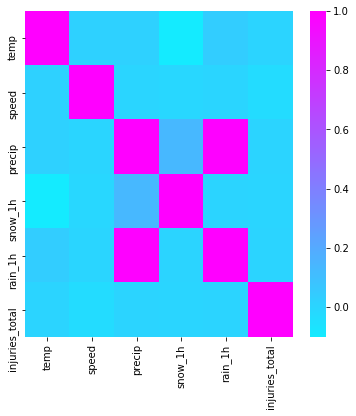

In [163]:
import seaborn as sns

plt.figure(figsize = (6,6))
sns.heatmap(df_cont.corr(), center=0.4, cmap = "cool");

# One Hot Encoding

In [164]:
# get rid of categories that have high correlation and others.
categoricals = ['month', 'year', 'weekday']


df_continuous = df_cont.copy()
df_ohe = crash_df[categoricals]
df_continuous = df_cont.copy()

string_me = ['month', 'year', 'weekday']
df_ohe[string_me] = df_ohe[string_me].astype(str)

# One hot encoding   
df_ohe = pd.get_dummies(df_ohe, drop_first=True)
df_final = pd.concat([df_continuous, df_ohe], axis=1)

In [165]:
pd.options.display.max_columns = 100
df_final.head()

,temp,speed,precip,snow_1h,rain_1h,injuries_total,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,year_2017,year_2018,year_2019,year_2020,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,272.15,27.062,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,272.15,24.834,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,272.15,26.004,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,272.15,16.526,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,272.15,18.136,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [166]:
#df_final.dropna(inplace=True)

In [167]:
#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression



X = df_final.drop([target], axis=1)
y = df_final[target]
reg = LinearRegression().fit(X, y)  # my regression object


# Good time to do a baseline r_squared calculation
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(reg, X, y, scoring='r2', cv=crossvalidation))

# Do the actual regression
reg.fit(X, y)
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:>12}: {}'.format(var, coefficients[var]))

print('Baseline r_squared val:', baseline)

        temp: 0.00013189975647773805
       speed: -0.0014608245213471602
      precip: 653023.614111617
     snow_1h: -653023.6140489706
     rain_1h: -653023.6138692866
    month_10: 0.004345114320078231
    month_11: 0.00435995732065842
    month_12: 0.005095944258391456
     month_2: -0.0012854945414488945
     month_3: -0.0018954342383942998
     month_4: -0.0014131761344686362
     month_5: -0.00029916822729338934
     month_6: -0.0004966122691477544
     month_7: 0.0022714452205850567
     month_8: 0.002273224355845736
     month_9: 0.003351196544602978
   year_2017: 0.008979745751526696
   year_2018: 0.019818171667697455
   year_2019: 0.02113552710239148
   year_2020: 0.019901001671781476
   weekday_1: -9.382771456187966e-05
   weekday_2: 0.0005786373539733942
   weekday_3: 0.0005694699522018734
   weekday_4: 0.0018513264838079782
   weekday_5: 0.003985771517834281
   weekday_6: 0.002798809781260288
Baseline r_squared val: 0.003107247412048331


In [168]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(reg, X, y, scoring='r2', cv=crossvalidation))


#preprocessed.columns 
baseline

0.003107247412048331

I need more information about the intersection other than just names.
I need descriptive info, but it isn't available in violations table.  Crash data does have some stuff though

In [169]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224911 entries, 0 to 1224910
Data columns (total 27 columns):
temp              1224911 non-null float64
speed             1224911 non-null float64
precip            1224911 non-null float64
snow_1h           1224911 non-null float64
rain_1h           1224911 non-null float64
injuries_total    1224911 non-null int64
month_10          1224911 non-null uint8
month_11          1224911 non-null uint8
month_12          1224911 non-null uint8
month_2           1224911 non-null uint8
month_3           1224911 non-null uint8
month_4           1224911 non-null uint8
month_5           1224911 non-null uint8
month_6           1224911 non-null uint8
month_7           1224911 non-null uint8
month_8           1224911 non-null uint8
month_9           1224911 non-null uint8
year_2017         1224911 non-null uint8
year_2018         1224911 non-null uint8
year_2019         1224911 non-null uint8
year_2020         1224911 non-null uint8
weekday_1       

In [62]:
# camera




int_df = pd.read_sql_query('''
                                    WITH v as
                                        (SELECT intersection,
                                                violations,
                                                month,
                                                dat as day,
                                                weekday,
                                                year
                                        FROM daily_violations
                                        GROUP BY intersection
                                        ),
                                    cr as
                                        (SELECT intersection,
                                                COUNT(crash_record_id) as n_crash,
                                                SUM(injuries_total) as injuries,
                                                SUM(injuries_fatal) as deaths
                                         FROM signal_crashes
                                         GROUP BY intersection
                                         ORDER BY intersection
                                         )
                                    SELECT v.intersection, v.violations, cr.n_crash, cr.injuries, cr.deaths
                                    FROM v
                                    LEFT JOIN cr
                                        ON cr.intersection=v.intersection
                                    GROUP BY v.intersection
                                         
                                    ''', conn)

DatabaseError: Execution failed on sql '
                                    WITH v as
                                        (SELECT intersection,
                                                violations,
                                                month,
                                                dat as day,
                                                weekday,
                                                year
                                        FROM daily_violations
                                        GROUP BY intersection
                                        ),
                                    cr as
                                        (SELECT intersection,
                                                COUNT(crash_record_id) as n_crash,
                                                SUM(injuries_total) as injuries,
                                                SUM(injuries_fatal) as deaths
                                         FROM signal_crashes
                                         GROUP BY intersection
                                         ORDER BY intersection
                                         )
                                    SELECT v.intersection, v.violations, cr.n_crash, cr.injuries, cr.deaths
                                    FROM v
                                    LEFT JOIN cr
                                        ON cr.intersection=v.intersection
                                    GROUP BY v.intersection
                                         
                                    ': no such column: dat